<a href="https://colab.research.google.com/github/cluePrints/course-v3/blob/master/fastai3_part2_00_matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from torch import tensor
import numpy as np
import torch

In [0]:
def test_roughly_eq(m1, m2, tolerance=1e-5):
  assert ((m1-m2).abs() > tolerance).sum() == 0, f"Expected:\n {m1}\n But actual was: \n {m2}"


def check_can_multiply_3x1_and_1x3(func):
  tensor1 = torch.arange(0, 3, 1.).unsqueeze(1)
  tensor2 = (torch.arange(0, 3, 1.)*10).unsqueeze(0)
  torch_mul = tensor1 @ tensor2
  own_mul = func(tensor1, tensor2)

  test_roughly_eq(torch_mul, own_mul)

def check_can_multiply_3x2_and_2x3(func):
  tensor1 = torch.arange(0, 3, 1.).unsqueeze(1).repeat((1, 2))
  tensor2 = (torch.arange(0, 3, 1.)*10).unsqueeze(0).repeat((2, 1))
  torch_mul = tensor1 @ tensor2
  own_mul = func(tensor1, tensor2)

  test_roughly_eq(torch_mul, own_mul)
  
def run_tests(func):
  check_can_multiply_3x1_and_1x3(func)
  check_can_multiply_3x2_and_2x3(func)

def matmul_1(ltensor, rtensor):
  result = torch.zeros(ltensor.shape[0], rtensor.shape[1])
  for lrow in range(ltensor.shape[0]):
    for rcol in range(rtensor.shape[1]):
      for k in range(ltensor.shape[1]):
        result[lrow, rcol] += ltensor[lrow, k] * rtensor[k, rcol];
  return result;

run_tests(matmul_1)

In [0]:
def matmul_2(ltensor, rtensor):
  result = torch.zeros(ltensor.shape[0], rtensor.shape[1])
  for lrow in range(ltensor.shape[0]):
    for rcol in range(rtensor.shape[1]):
      result[lrow, rcol] = (ltensor[lrow, :] * rtensor[:, rcol]).sum();
  return result;

run_tests(matmul_2)

In [0]:
def matmul_3(ltensor, rtensor):
  result = torch.zeros(ltensor.shape[0], rtensor.shape[1])
  for lrow in range(ltensor.shape[0]):
    # result[lrow, rcol] = (ltensor[lrow, :] * rtensor[:, rcol]).sum();
    result[lrow, :] = (ltensor[lrow, :].unsqueeze(-1) * rtensor).sum(dim=0)
  return result;

run_tests(matmul_3)

In [0]:
def matmul_4(ltensor, rtensor):
  return torch.einsum('ij,jk -> ik', ltensor, rtensor);

run_tests(matmul_4)

In [8]:
import timeit
from collections import defaultdict
series = defaultdict(list)

tested_functions = {
    'for loops': matmul_1,
    'broadcast1': matmul_2,
    'broadcast2': matmul_3,
    'einsum': matmul_4,
    'torch': lambda m,n: m @ n
}

for size in [10, 100, 150, 200]:
  print(f'\n= Testing size {size}')
  series['size'].append(size)  
  tensor1 = torch.arange(0, size, 1.).unsqueeze(1)
  tensor2 = (torch.arange(0, size, 1.)*10).unsqueeze(0)
  for name, f in tested_functions.items():
    print(f'Timing {name}')
    elapsed = timeit.timeit('f(tensor1, tensor2)', globals=globals(), number=15)
    series[name].append(elapsed)


= Testing size 10
Timing for loops
Timing broadcast1
Timing broadcast2
Timing einsum
Timing torch

= Testing size 100
Timing for loops
Timing broadcast1
Timing broadcast2
Timing einsum
Timing torch

= Testing size 150
Timing for loops
Timing broadcast1
Timing broadcast2
Timing einsum
Timing torch

= Testing size 200
Timing for loops
Timing broadcast1
Timing broadcast2
Timing einsum
Timing torch


In [0]:
import pandas as pd
sizes = series['size']
del series['size']
df = pd.DataFrame(series, index=sizes)

In [10]:
df

,broadcast1,broadcast2,einsum,for loops,torch
10,0.026956,0.003245,0.000740,0.030554,0.000307
100,2.525241,0.028746,0.000793,2.532421,0.000383
150,5.679738,0.045510,0.000761,5.645897,0.000411
200,10.064257,0.063894,0.000828,10.050815,0.000439


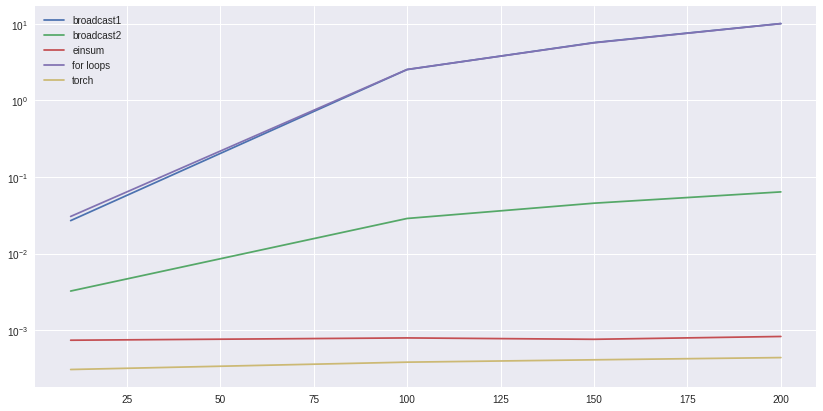

In [11]:
df.plot(figsize=(14, 7), logy=True)

# Named tensor

In [12]:
!pip install git+https://github.com/harvardnlp/namedtensor -q

In [13]:
from namedtensor import ntorch
a = ntorch.tensor(torch.arange(0, 3, 1.).unsqueeze(1).repeat((1, 2)), names=('rows', 'cols'))
b = ntorch.tensor((torch.arange(0, 3, 1.)*10).unsqueeze(0).repeat((2, 1)), names=('rows', 'cols'))
b

NamedTensor(
	tensor([[ 0., 10., 20.],
        [ 0., 10., 20.]]),
	('rows', 'cols'))

In [14]:
a[{'rows': 0}]

NamedTensor(
	tensor([0., 0.]),
	('cols',))

In [15]:
b[{'rows': 0}]

NamedTensor(
	tensor([ 0., 10., 20.]),
	('cols',))

In [16]:
# Note to self: elementwise access looks ugly and not really designed for
a[{'rows': 0, 'cols': 0}].numpy() * b[{'rows': 0, 'cols': 0}].numpy()

0.0

In [17]:
a[{'rows': 0, 'cols': 0}].numpy()

array(0., dtype=float32)

In [18]:
def named_mul_1(ltensor, rtensor):
  result = torch.zeros(ltensor.shape['rows'], rtensor.shape['cols'])
  for lrow in range(ltensor.shape['rows']):
    for rcol in range(rtensor.shape['cols']):
      for k in range(ltensor.shape['cols']):
        result[lrow, rcol] += ltensor[{'rows': lrow, 'cols': k}].numpy() * rtensor[{'rows': k, 'cols': rcol}].numpy();
  return result;

named_mul_1(a, b)

tensor([[ 0.,  0.,  0.],
        [ 0., 20., 40.],
        [ 0., 40., 80.]])

In [19]:
a.shape

OrderedDict([('rows', 3), ('cols', 2)])

In [20]:
a

NamedTensor(
	tensor([[0., 0.],
        [1., 1.],
        [2., 2.]]),
	('rows', 'cols'))

In [21]:
b

NamedTensor(
	tensor([[ 0., 10., 20.],
        [ 0., 10., 20.]]),
	('rows', 'cols'))

In [22]:
# Note to self: broadcasting looks nicer in writing, but in here both dims are broadcasted which is a bummer, especially given unsqueze ban
a[{'rows':1}] * b[{'cols': 2}]

NamedTensor(
	tensor([[20., 20.],
        [20., 20.]]),
	('rows', 'cols'))

In [23]:
a[{'rows':1}].numpy() * b[{'cols': 2}].numpy()

array([20., 20.], dtype=float32)

In [24]:
(a[{'rows':1}] * b[{'cols': 2}])

NamedTensor(
	tensor([[20., 20.],
        [20., 20.]]),
	('rows', 'cols'))

In [25]:
a[{'rows':1}]

NamedTensor(
	tensor([1., 1.]),
	('cols',))

In [26]:
b[{'cols': 2}]

NamedTensor(
	tensor([20., 20.]),
	('rows',))

In [27]:
a[{'rows':1}] * b[{'cols': 2}]

NamedTensor(
	tensor([[20., 20.],
        [20., 20.]]),
	('rows', 'cols'))

In [28]:
def named_mul_2(ltensor, rtensor):
  result = ntorch.zeros((ltensor.shape['rows'], rtensor.shape['cols']), names=('cols', 'rows'))
  any_ = 0
  for lrow in range(ltensor.shape['rows']):
    for rcol in range(rtensor.shape['cols']):
      # Note to self: scalars are so unintuitive Dimension () does not exist. Available dimensions are ()
      broadcasted_on_both_dims = (ltensor[{'rows': lrow}] * rtensor[{'cols': rcol}])
      single_dim_result = broadcasted_on_both_dims[{'rows': any_}]
      result[{'rows': lrow, 'cols': rcol}] = int(single_dim_result.sum().numpy())
  return result;

named_mul_2(a, b)

NamedTensor(
	tensor([[ 0.,  0.,  0.],
        [ 0., 20., 40.],
        [ 0., 40., 80.]]),
	('cols', 'rows'))

In [33]:
# result[lrow, rcol] = (ltensor[lrow, :] * rtensor[:, rcol]).sum();
# result[lrow, :] = (ltensor[lrow, :].unsqueeze(-1) * rtensor).sum(dim=0)
# Note to self: I guess that's the end of it, this sort of encapsulation makes it difficult for two different dimensions to interact looks good on images though
a[{'rows': 1}] * b

AssertionError: ignored